# LAB 01: Data collection and visualization

### Team information

Class : 22KHDL

|Student's ID| Name |
|------------|--------------|
|22127460| Quách Trần Quán Vinh|
|22127478| Nguyễn Hoàng Trung Kiên|

### Import libraries

- Libraries to handle and visualize data

In [490]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import numpy as np

- Libraries to collect data

In [491]:
from requests import get, post
from sys import exit
import os
from dotenv import load_dotenv

## 1. Data collection

In this section, we will use [Chartmetric API](https://chartmetric.com/features/developer-api) to collect music data.

### 1.1. Crawling data

- Authenticate Chartmetric API access.

In [492]:
# load_dotenv()

# HOST = 'https://api.chartmetric.com'
# TOKEN = os.getenv('REFRESH_TOKEN')
# res = post(f'{HOST}/api/token', json={"refreshtoken": TOKEN})
# if res.status_code != 200:
#     print(f'ERROR: received a {res.status_code} instead of 200 from /api/token')
#     exit(1)

# access_token = res.json()['token']

- Scrape data and save to a `.csv` file.

In [493]:
# def Get(uri):
#     return get(f'{HOST}{uri}', headers={'Authorization': f'Bearer {access_token}'})

# tracks = []
# for i in range(0, 10000, 100):
#     res = Get(f'/api/track/list/filter?limit=100&offset={i}')
#     if res.status_code != 200:
#         print(f'ERROR: received a {res.status_code} instead of 200 from /api/track/list/filter')
#         exit(1)
        
#     objs = res.json()['obj']

#     for obj in objs:
#         track = {
#             'id': obj['cm_track'],
#             'track_name': obj['name'],
#             'album_name': obj['album'][0]['name'],
#             'release_date': obj['album'][0]['release_date'],
#             'artist': [artist['name'] for artist in obj['artist']],
#             'genre': obj['genre'],
#             'explicit': obj['explicit'],
#             'score': obj['score'],
#         }
        
#         for key in obj['latest'].keys():
#             if key == 'rank':
#                 continue
#             track[key] = obj['latest'][key]
#         tracks.append(track)
    
# tracks_df = pd.DataFrame(tracks)
# tracks_df.to_csv('tracks_chartmetric.csv', index=False)

### 1.2. Exploring and preprocessing data

#### 1.2.1. Data exploration

- Read data 

In [494]:
df = pd.read_csv('tracks_chartmetric.csv')
df

,id,track_name,album_name,release_date,artist,genre,explicit,score,airplay_streams,amazon_playlist_count,deezer_playlist_count,itunes_playlist_count,shazam_count,siriusxm_streams,soundcloud_plays,spotify_playlist_count,spotify_playlist_total_reach,spotify_plays,spotify_popularity,spotify_ed_playlist_count,spotify_ed_playlist_total_reach,tidal_popularity,tiktok_posts,tiktok_top_videos_likes,tiktok_top_videos_views,youtube_likes,youtube_playlist_count,youtube_views
0,138071658,APT.,APT.,2024-10-18,"['ROSÉ', 'Bruno Mars']","['Pop', 'K-Pop', 'Dance']",False,0.966846,336709.0,NaN,179.0,9.0,NaN,459.0,2050566.0,90419.0,274203572.0,1.222631e+09,92.0,164.0,109435710.0,NaN,9058000.0,938397392.0,1.256294e+10,14266985.0,373.0,1.180584e+09
1,134780977,Die With A Smile,Die With A Smile,2024-08-16,"['Lady Gaga', 'Bruno Mars']",['Pop'],False,0.588069,466036.0,145.0,176.0,348.0,10242973.0,12.0,NaN,180800.0,278012420.0,1.938871e+09,97.0,187.0,105551916.0,NaN,2600000.0,595192902.0,4.572196e+09,843476.0,2.0,4.126108e+07
2,120611262,BIRDS OF A FEATHER,HIT ME HARD AND SOFT,2024-05-17,['Billie Eilish'],"['Pop', 'Alternative', 'Alternative Rock']",True,0.499970,670692.0,142.0,166.0,404.0,7881055.0,102.0,NaN,195827.0,298624666.0,2.126765e+09,95.0,208.0,112169955.0,NaN,1500000.0,522050067.0,4.114507e+09,6220211.0,262.0,5.426091e+08
3,118981138,Espresso,Espresso,2024-04-12,['Sabrina Carpenter'],['Pop'],True,0.455367,938885.0,186.0,192.0,314.0,5698679.0,710.0,NaN,188214.0,215527109.0,1.977140e+09,85.0,188.0,42425762.0,NaN,928200.0,312540065.0,2.890147e+09,5964770.0,243.0,6.682628e+08
4,120189440,Not Like Us,Not Like Us,2024-05-04,['Kendrick Lamar'],['Hip-Hop/Rap'],True,0.448599,416457.0,171.0,113.0,336.0,6001425.0,133.0,NaN,236267.0,202931595.0,1.201296e+09,93.0,150.0,68921402.0,NaN,2900000.0,420232035.0,3.423082e+09,12687671.0,278.0,6.773596e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,142018026,Un Dolor,Tesoros de Colección,2024-11-27,"[""Los Yonic's""]",['Others'],False,0.012359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,13.0,5.364438e+07,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,17469970,Wait,Wait,2017-10-31,['Maroon 5'],['Pop'],False,0.012366,17989.0,12.0,5.0,39.0,2850478.0,119.0,647734.0,30772.0,12576658.0,4.472374e+08,57.0,15.0,1991.0,NaN,1766.0,251574.0,3.703557e+06,1588524.0,10.0,2.174645e+08
9997,96743526,Niagara Falls (Foot or 2) [with Travis Scott &...,HEROES & VILLAINS,2022-12-02,"['Metro Boomin', 'Travis Scott', '21 Savage']",['Hip-Hop/Rap'],False,0.012430,217.0,NaN,NaN,2.0,NaN,NaN,NaN,6096.0,610413.0,3.890496e+08,41.0,0.0,0.0,NaN,NaN,NaN,NaN,224742.0,NaN,2.621794e+07
9998,15674336,We R Who We R,We R Who We R,2010-10-26,['Kesha'],"['Hip-Hop/Rap', 'Pop', 'Electronic']",False,0.012362,8480.0,4.0,15.0,83.0,1743329.0,95.0,NaN,69065.0,33843487.0,3.479367e+08,69.0,18.0,1630423.0,NaN,172954.0,49939590.0,3.771906e+08,1083666.0,10.0,2.178190e+08


- Data information

In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               10000 non-null  int64  
 1   track_name                       10000 non-null  object 
 2   album_name                       9999 non-null   object 
 3   release_date                     10000 non-null  object 
 4   artist                           10000 non-null  object 
 5   genre                            10000 non-null  object 
 6   explicit                         9775 non-null   object 
 7   score                            10000 non-null  float64
 8   airplay_streams                  8366 non-null   float64
 9   amazon_playlist_count            6898 non-null   float64
 10  deezer_playlist_count            7276 non-null   float64
 11  itunes_playlist_count            8434 non-null   float64
 12  shazam_count       

There are 1 ```int``` type column, 6 ```object``` type columns and 21 ```float``` type columns.

In [496]:
df.shape

(10000, 28)

The raw data contains 10000 rows and 28 columns

- Data columns

In [497]:
print(df.columns)

Index(['id', 'track_name', 'album_name', 'release_date', 'artist', 'genre',
       'explicit', 'score', 'airplay_streams', 'amazon_playlist_count',
       'deezer_playlist_count', 'itunes_playlist_count', 'shazam_count',
       'siriusxm_streams', 'soundcloud_plays', 'spotify_playlist_count',
       'spotify_playlist_total_reach', 'spotify_plays', 'spotify_popularity',
       'spotify_ed_playlist_count', 'spotify_ed_playlist_total_reach',
       'tidal_popularity', 'tiktok_posts', 'tiktok_top_videos_likes',
       'tiktok_top_videos_views', 'youtube_likes', 'youtube_playlist_count',
       'youtube_views'],
      dtype='object')


**Meaning of each columns**

| Column Name                         | Description |
|--------------------------------------|-------------|
| `id`                                 | Track's identifier |
| `track_name`                         | Name of the track |
| `album_name`                         | Name of the album the track belongs to |
| `release_date`                       | Track's release date |
| `artist`                             | Name of the artist of the track |
| `genre`                              | Track's genre |
| `explicit`                           | Indicates whether the track has explicit content (`True/False`) |
| `score`                              | Overall rating score of the track |
| `airplay_streams`                    | Number of times the track was streamed on radio platforms |
| `amazon_playlist_count`              | Number of Amazon Music playlists featuring the track |
| `deezer_playlist_count`              | Number of Deezer playlists featuring the track |
| `itunes_playlist_count`              | Number of Apple Music (iTunes) playlists featuring the track |
| `shazam_count`                       | Number of times the track was identified on Shazam |
| `siriusxm_streams`                   | Number of streams from SiriusXM radio |
| `soundcloud_plays`                   | Number of plays on SoundCloud |
| `spotify_playlist_count`             | Number of Spotify playlists featuring the track |
| `spotify_playlist_total_reach`       | Total reach (followers) of all Spotify playlists containing the track |
| `spotify_plays`                      | Number of times the track was played on Spotify |
| `spotify_popularity`                 | Popularity score of the track on Spotify |
| `spotify_ed_playlist_count`          | Number of Spotify editorial playlists featuring the track |
| `spotify_ed_playlist_total_reach`    | Total reach (followers) of all Spotify editorial playlists containing the track |
| `tidal_popularity`                   | Popularity score of the track on Tidal |
| `tiktok_posts`                       | Number of TikTok posts using the track |
| `tiktok_top_videos_likes`            | Total likes of the top TikTok videos using the track |
| `tiktok_top_videos_views`            | Total views of the top TikTok videos using the track |
| `youtube_likes`                      | Total number of likes on YouTube videos featuring the track |
| `youtube_playlist_count`             | Number of YouTube playlists containing the track |
| `youtube_views`                      | Total views of the track on YouTube |



#### 1.2.2. Data preprocessing

- Handle duplicates

In [498]:
df.duplicated().sum()

np.int64(29)

There are 29 duplicate records in the data so we will drop them.

In [499]:
df = df.drop_duplicates()

- Handle missing values

In [500]:
df.isna().sum()

id                                    0
track_name                            0
album_name                            1
release_date                          0
artist                                0
genre                                 0
explicit                            224
score                                 0
airplay_streams                    1629
amazon_playlist_count              3092
deezer_playlist_count              2717
itunes_playlist_count              1563
shazam_count                       1857
siriusxm_streams                   5635
soundcloud_plays                   7557
spotify_playlist_count              170
spotify_playlist_total_reach        170
spotify_plays                       216
spotify_popularity                  460
spotify_ed_playlist_count           170
spotify_ed_playlist_total_reach     170
tidal_popularity                   9971
tiktok_posts                       2037
tiktok_top_videos_likes            2804
tiktok_top_videos_views            2805


There are some columns which have high quantity of missing records. We will drop the columns that have over 2000 missing values.

In [501]:
df = df.drop(columns=['amazon_playlist_count', 'deezer_playlist_count', 'siriusxm_streams', 
                      'soundcloud_plays', 'tidal_popularity', 'tiktok_posts', 'tiktok_top_videos_likes', 
                      'tiktok_top_videos_views', 'youtube_playlist_count'])

Column ```id``` is not really meaningful for further analysis so we will remove it as well.

In [502]:
df = df.drop(columns='id')

For categorical columns, there are 2 columns that have missing values. They are ```album_name``` and ```explicit```. ```Explicit``` can be filled by **mode** since it only contains 1 of 2 values true/false. However, ```album_name``` cannot be determined by mode because it will not be true and reliable based on the data's domain knowledge which misrepresents the data. So the row with missing value in ```album_name``` column will be eliminated.

In [503]:
df = df.dropna(subset=['album_name']).copy()  
df['explicit'] = df['explicit'].astype(str)
mode_value = df['explicit'].mode()[0]
df['explicit'] = df['explicit'].fillna(mode_value).map(lambda x: str(x).lower() == 'true')

We will check the distribution of each numeric columns to decide which method of handling missing values would be approriate. (**Note:** This visualization is just a step to decide filling missing values method, not the main part of visualization of this Project.)

- Define numeric columns

In [504]:
numeric_cols = ['score', 'airplay_streams', 'itunes_playlist_count', 'shazam_count', 'spotify_playlist_count'	
                ,'spotify_playlist_total_reach', 'spotify_plays', 'spotify_popularity', 'spotify_ed_playlist_count',
                'spotify_ed_playlist_total_reach', 'youtube_likes', 'youtube_views']

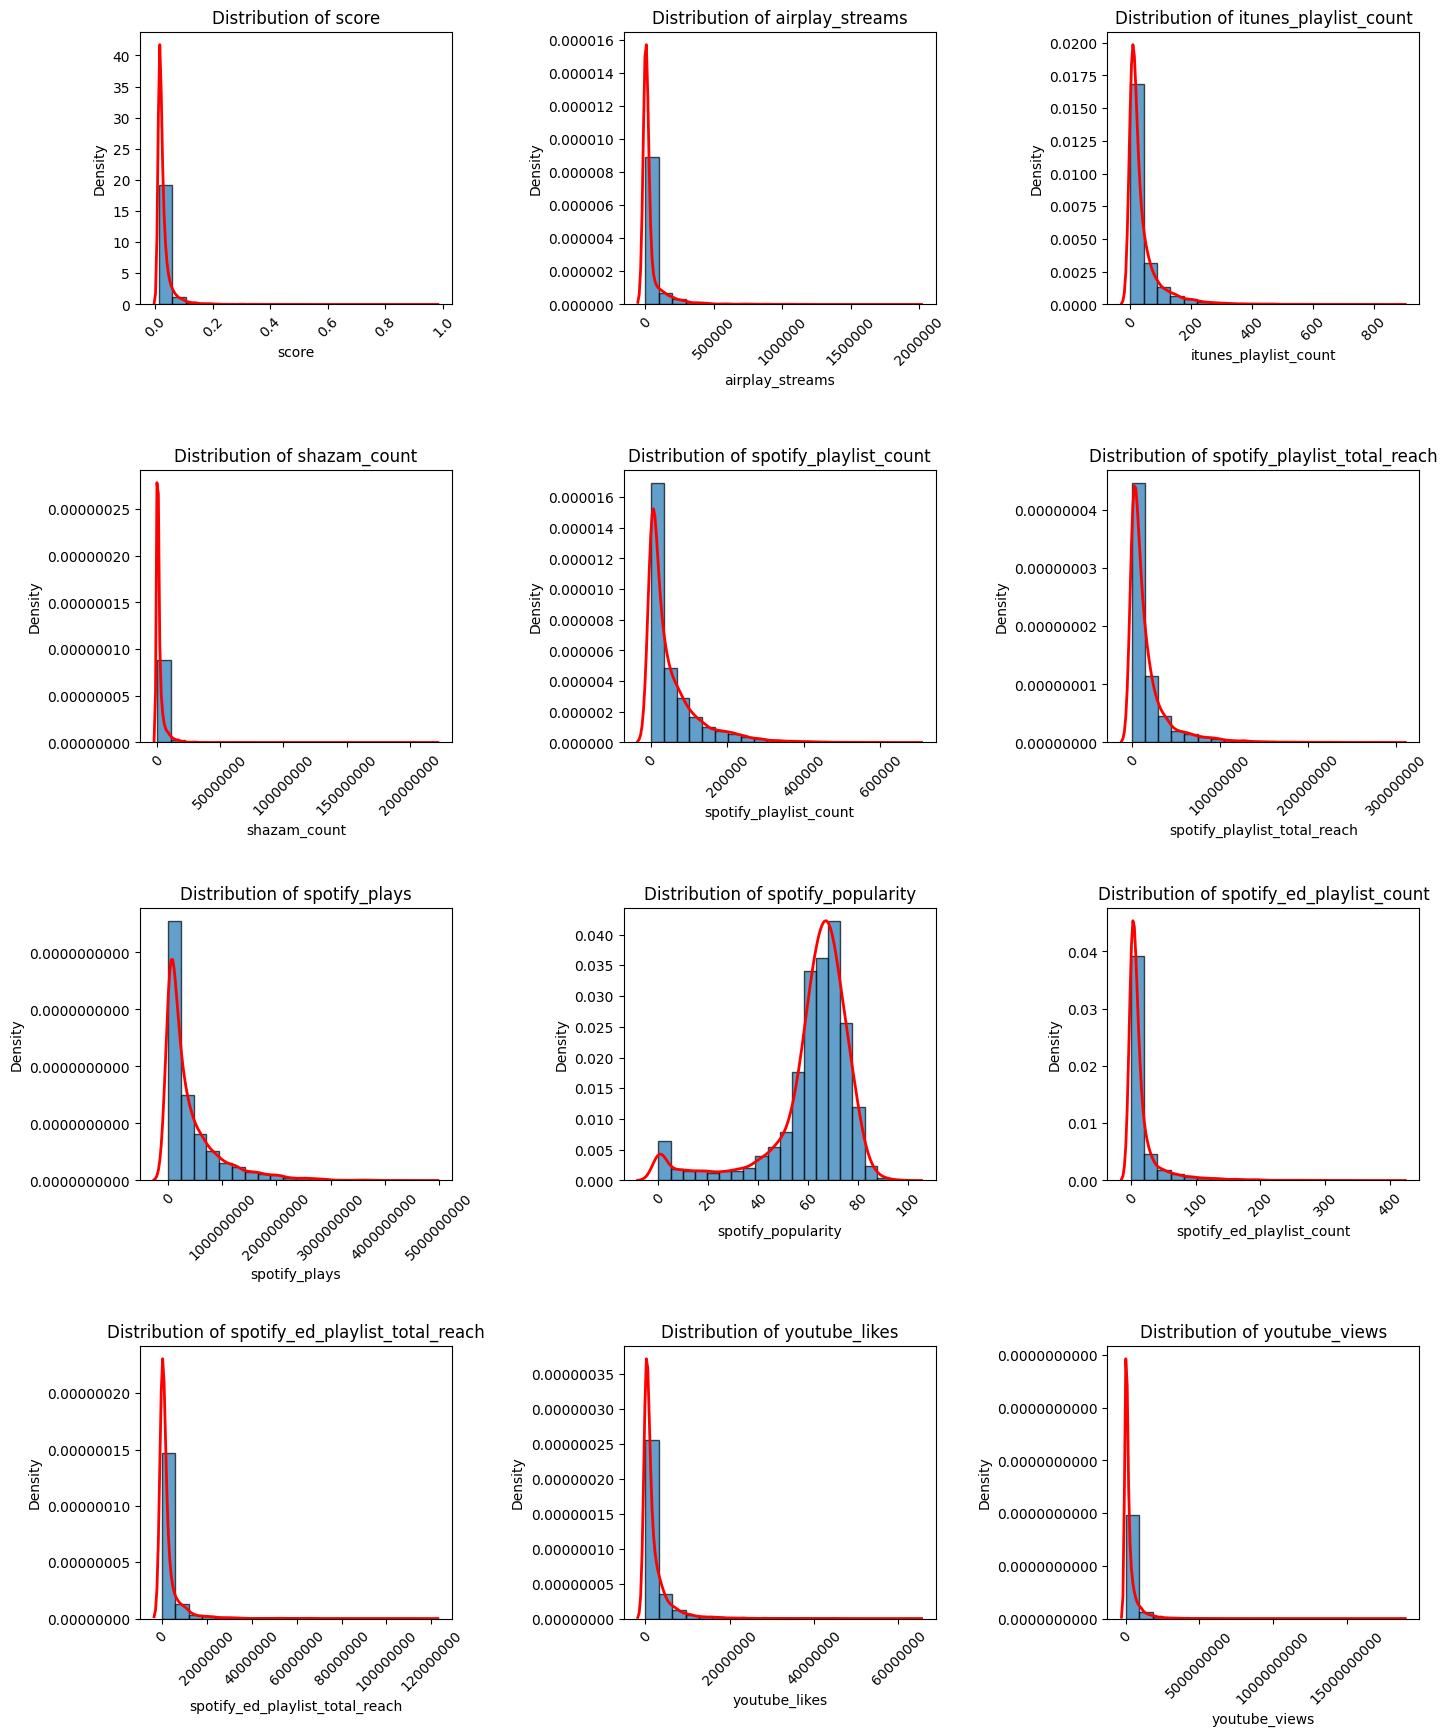

In [505]:
plt.figure(figsize=(15, 18))  

for i in range(len(numeric_cols)):
    plt.subplot(4, 3, i + 1)
    plt.hist(df[numeric_cols[i]], bins=20, edgecolor='black', alpha=0.7, density=True)
    sns.kdeplot(df[numeric_cols[i]], color='red', linewidth=2)
    plt.title(f'Distribution of {numeric_cols[i]}')
    plt.xlabel(numeric_cols[i])
    plt.ylabel('Density')
    plt.xticks(rotation=45)
    plt.ticklabel_format(style='plain', axis='both')  
    
plt.tight_layout(pad=3.0)
plt.show()

From the plot above we can see that the numeric columns have heavily right-skewed distribution because of some outliers.

$\rightarrow$ To handle this we will fill missing values with **median** for simplicity since the columns have low number of missing values so use this filling method will not effect the distribution.

In [506]:
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

- Check missing values again

In [507]:
df.isna().sum()

track_name                         0
album_name                         0
release_date                       0
artist                             0
genre                              0
explicit                           0
score                              0
airplay_streams                    0
itunes_playlist_count              0
shazam_count                       0
spotify_playlist_count             0
spotify_playlist_total_reach       0
spotify_plays                      0
spotify_popularity                 0
spotify_ed_playlist_count          0
spotify_ed_playlist_total_reach    0
youtube_likes                      0
youtube_views                      0
dtype: int64

The data now has no missing values.

- Handle data format

We take a look through the data types.

In [508]:
df.dtypes

track_name                          object
album_name                          object
release_date                        object
artist                              object
genre                               object
explicit                              bool
score                              float64
airplay_streams                    float64
itunes_playlist_count              float64
shazam_count                       float64
spotify_playlist_count             float64
spotify_playlist_total_reach       float64
spotify_plays                      float64
spotify_popularity                 float64
spotify_ed_playlist_count          float64
spotify_ed_playlist_total_reach    float64
youtube_likes                      float64
youtube_views                      float64
dtype: object

All columns that has ```float``` type (except ```score```) should be converted into ```int``` type since they represent count, likes, views, etc.

In [509]:
columns = [
    'airplay_streams',                  
    'itunes_playlist_count',            
    'shazam_count',                      
    'spotify_playlist_count',  
    'spotify_playlist_total_reach',  
    'spotify_plays',        
    'spotify_popularity',
    'spotify_ed_playlist_count',   
    'spotify_ed_playlist_total_reach',     
    'youtube_likes',                    
    'youtube_views'
]

In [510]:
df[columns] = df[columns].astype(int)

```release_date``` column should have ```datetime``` type.

In [511]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

Check data type again.

In [512]:
df.dtypes

track_name                                 object
album_name                                 object
release_date                       datetime64[ns]
artist                                     object
genre                                      object
explicit                                     bool
score                                     float64
airplay_streams                             int64
itunes_playlist_count                       int64
shazam_count                                int64
spotify_playlist_count                      int64
spotify_playlist_total_reach                int64
spotify_plays                               int64
spotify_popularity                          int64
spotify_ed_playlist_count                   int64
spotify_ed_playlist_total_reach             int64
youtube_likes                               int64
youtube_views                               int64
dtype: object

The columns now have correct types.

The columns ```artist``` and ```genre``` stores value as list, but the data treated them as string type, for ease use, we will remove the characters ```[]``` and ```''``` in them.

In [513]:
df['artist'] = (df['artist']
                .astype(str)  
                .str.replace(r"[\[\]']", "", regex=True)
                .apply(lambda x: re.split(r',\s*', x) if x.strip() else []))

df['genre'] = (df['genre']
               .astype(str)
               .str.replace(r"[\[\]']", "", regex=True)
               .apply(lambda x: re.split(r',\s*', x) if x.strip() else []))

### Data after being preprocessed

In [514]:
df.head()

,track_name,album_name,release_date,artist,genre,explicit,score,airplay_streams,itunes_playlist_count,shazam_count,spotify_playlist_count,spotify_playlist_total_reach,spotify_plays,spotify_popularity,spotify_ed_playlist_count,spotify_ed_playlist_total_reach,youtube_likes,youtube_views
0,APT.,APT.,2024-10-18,"[ROSÉ, Bruno Mars]","[Pop, K-Pop, Dance]",False,0.966846,336709,9,574324,90419,274203572,1222630989,92,164,109435710,14266985,1180584071
1,Die With A Smile,Die With A Smile,2024-08-16,"[Lady Gaga, Bruno Mars]",[Pop],False,0.588069,466036,348,10242973,180800,278012420,1938870521,97,187,105551916,843476,41261078
2,BIRDS OF A FEATHER,HIT ME HARD AND SOFT,2024-05-17,[Billie Eilish],"[Pop, Alternative, Alternative Rock]",True,0.499970,670692,404,7881055,195827,298624666,2126764510,95,208,112169955,6220211,542609125
3,Espresso,Espresso,2024-04-12,[Sabrina Carpenter],[Pop],True,0.455367,938885,314,5698679,188214,215527109,1977140175,85,188,42425762,5964770,668262835
4,Not Like Us,Not Like Us,2024-05-04,[Kendrick Lamar],[Hip-Hop/Rap],True,0.448599,416457,336,6001425,236267,202931595,1201295523,93,150,68921402,12687671,677359643


Store data into csv.

In [515]:
df.to_csv('tracks_preprocessed.csv')

## 2. Data visualization

### 2.1. Data introduction

#### 2.1.1. Introduction

In this analysis, we are using the Chartmetrics dataset, a rich source of music industry data compiled by Chartmetrics to track artist and song performance across platforms like YouTube, Spotify, TikTok, ...   

For this lab, we will mainly focus on analyzing tracks and get some useful insights using data visualization and statistics.

#### 2.1.2. Sample size

In [516]:
df.shape

(9970, 18)

The data now has 9970 rows (> 3000 rows) with meaningful columns suitable for analysis.

#### 2.1.3. Structures

In [517]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9970 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   track_name                       9970 non-null   object        
 1   album_name                       9970 non-null   object        
 2   release_date                     9970 non-null   datetime64[ns]
 3   artist                           9970 non-null   object        
 4   genre                            9970 non-null   object        
 5   explicit                         9970 non-null   bool          
 6   score                            9970 non-null   float64       
 7   airplay_streams                  9970 non-null   int64         
 8   itunes_playlist_count            9970 non-null   int64         
 9   shazam_count                     9970 non-null   int64         
 10  spotify_playlist_count           9970 non-null   int64         
 

#### 2.1.4. Statistics description

In [518]:
df[numeric_cols].describe()

,score,airplay_streams,itunes_playlist_count,shazam_count,spotify_playlist_count,spotify_playlist_total_reach,spotify_plays,spotify_popularity,spotify_ed_playlist_count,spotify_ed_playlist_total_reach,youtube_likes,youtube_views
count,9970.000000,9.970000e+03,9970.000000,9.970000e+03,9970.000000,9.970000e+03,9.970000e+03,9970.000000,9970.000000,9.970000e+03,9.970000e+03,9.970000e+03
mean,0.029962,3.536284e+04,36.809328,1.725359e+06,51965.127482,1.665450e+07,4.059216e+08,61.357071,16.120963,2.721139e+06,1.822432e+06,2.545591e+08
std,0.032211,1.027143e+05,55.493781,4.312284e+06,70388.260864,2.451138e+07,5.315570e+08,16.863358,30.313205,7.120823e+06,3.374848e+06,5.250900e+08
min,0.012359,1.000000e+00,1.000000,1.000000e+00,1.000000,0.000000e+00,1.066000e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,2.000000e+00
25%,0.015237,4.507500e+02,8.000000,2.290188e+05,4924.000000,2.611963e+06,6.057779e+07,59.000000,2.000000,1.506650e+04,2.432945e+05,2.613770e+07
50%,0.020243,3.197000e+03,18.000000,5.743240e+05,24257.000000,8.233730e+06,2.029017e+08,65.000000,6.000000,5.784450e+05,7.183990e+05,8.610588e+07
75%,0.031386,1.762950e+04,39.000000,1.460020e+06,70820.750000,1.990739e+07,5.333236e+08,71.000000,15.000000,2.382945e+06,1.922136e+06,2.465413e+08
max,0.966846,1.962831e+06,875.000000,2.197945e+08,673695.000000,2.986247e+08,4.723352e+09,97.000000,409.000000,1.194549e+08,6.371121e+07,1.871716e+10


### 2.2. Visualization objectives

There are 2 members in our team, so we decide to derive 4 objectives:

#### 1. How do popular Pop tracks reach their audience on Spotify from 2020 to 2024?

**Benefits**
- Helps the artists and producers release tracks that can increase their engagement, keep up with the trends and reach a wider audience. 

- Enhances playlists, keeps listeners engaged, and recommends the best mix of Pop songs.

**Features used in data**

- ```release_date```, ```genre```, ```spotify_playlist_count```, ```spotify_playlist_total_reach```, ```spotify_plays```, ```spotify_popularity```

#### 2. What are the seasonal trends of high-scoring tracks on YouTube?

**Benefits**
- Helps the artists, producers or content creators make strategies to release trending tracks, from that maximizing views and likes count on Youtube platform.

- Viewers can discover the best music videos or playlists for every seasons.

**Features used in data**

- ```track_name```, ```score```, ```release date```, ```youtube_likes```, ```youtube_views```

#### 3. Which artist has the greatest influence on Spotify, and is this related to their music genre?

**Benefits**
- Provides insights for artists, music producers to review their current work and make some useful strategies for the future plans.

- Helps to understand if the successful artists made huge influence across different platforms.

- Enhances playlist filter by featuring artists with strong cross-platform influence.

**Features used in data**  
- `genre`, `artist`, `spotify_plays`

#### 4. How does explicit content affect a track's popularity across platform?

**Benefits**
- Helps artists and composers alter the lyrics which is suitable for the audience expectation for maximum reach and engagement.

- Reveals audience preferences for explicit vs. clean content across different genres whether they prefer the tracks that have explicit content or not.

**Features used in data**
- ```genre```, ```explicit```, ```score```, ```spotify_popularity```, `spotify_plays`, ...

### 2.3. Analyzing objectives

#### 3. Which song by the top 10 artists on Spotify has the greatest influence, and is this related to the music genre?
##### First, we visualize top 10 artists with highest `spotify_plays` in entire dataset

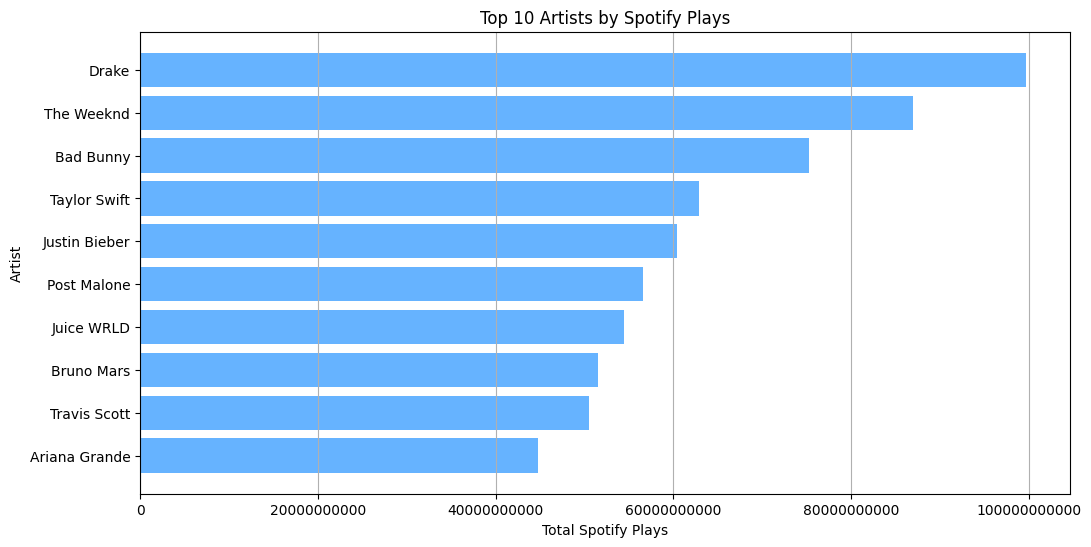

In [527]:
df_exploded = df.explode('artist').reset_index(drop=True).dropna(subset=['artist'])
top_artists_df = df_exploded.groupby(['artist'])['spotify_plays'].sum().sort_values(ascending=False).nlargest(10)

plt.figure(figsize=(12,6))

plt.barh(y=top_artists_df.index[::-1], width=top_artists_df[::-1], color='#66b3ff')
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel("Total Spotify Plays")
plt.ylabel("Artist")
plt.grid(axis='x')
plt.title("Top 10 Artists by Spotify Plays");

##### Then, we take a look on the most influenced song of that top 10 artists.

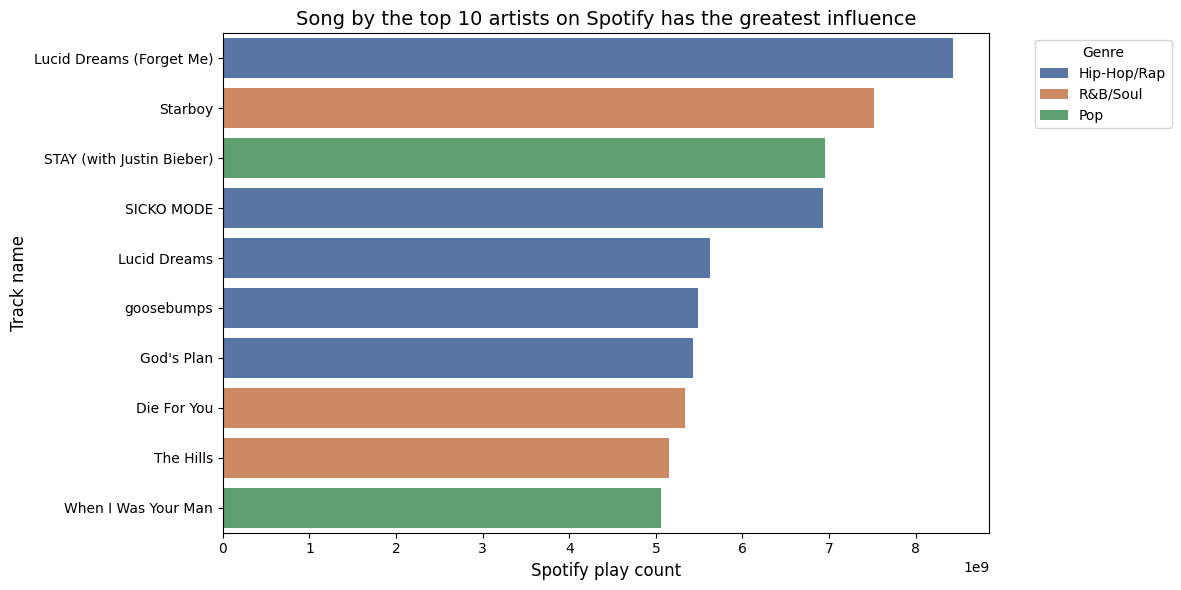

In [528]:
df_exploded = df.explode('genre').reset_index(drop=True).dropna(subset=['genre'])

df_exploded = df_exploded.explode('artist').reset_index(drop=True).dropna(subset=['artist'])

top_artists_with_genre = df_exploded[df_exploded['artist'].isin(top_artists_df.index)]
top_tracks = top_artists_with_genre.groupby(['track_name', 'genre'])['spotify_plays'].sum().reset_index()
top_tracks = top_tracks.sort_values(by='spotify_plays', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_tracks, x='spotify_plays', y='track_name', hue='genre', palette='deep', dodge=False)
plt.title('Song by the top 10 artists on Spotify has the greatest influence', fontsize=14)
plt.xlabel('Spotify play count', fontsize=12)
plt.ylabel('Track name', fontsize=12)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout();

##### Conclusion

The song "Lucid Dreams (Forget Me)" has the greatest influence based on Spotify play count, highlighting the dominance of Hip-Hop/Rap in streaming popularity. And most of the top artists are also rappers. Thus, we can conclude that Hip-Hop/Rap tracks are very popular nowadays.

While Hip-Hop/Rap appears most frequently among the top tracks, the presence of R&B/Soul and Pop suggests that high influence is not exclusive to a single genre but rather depends on the artist's reach and the song's appeal.

#### 4. How does explicit content affect a track's popularity across platform?
First, let's breakdown the objectives into smaller analysis to get more insights
##### What is the distribution of explicit and non-explicit tracks over the entire dataset.

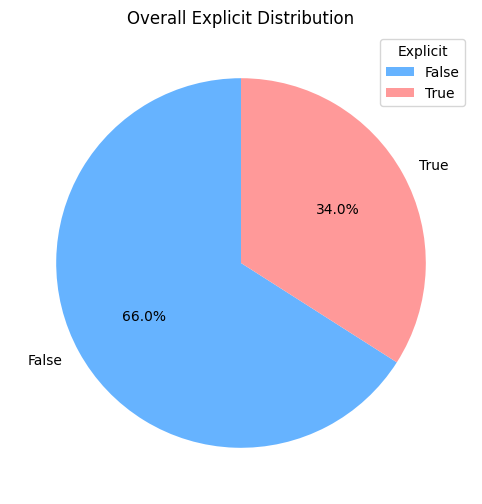

In [529]:
overall_explicit = df.groupby('explicit').size()
plt.figure(figsize=(12,6))
plt.pie(overall_explicit, labels=overall_explicit.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Overall Explicit Distribution')
plt.legend(title='Explicit');

As we can see, non-explicit content accounted for the largest proportion in surveyed tracks at around 66%. Therefore, we can conclude that the majority of tracks is non-explicit content, so that most of the tracks are easily reached by audience of all ages. 

##### Let's analyze more on how explicit and non-explicit content affect on popularity (views and likes) across platforms (Spotify, Youtube, Airplay, Itunes and Shazam)

Let's take a look on the scale of the data.

In [522]:
categories = df[numeric_cols].columns

min_max_df = pd.DataFrame({
    'Min': df[categories].min(),
    'Max': df[categories].max()
})

min_max_df

,Min,Max
score,0.012359,9.668463e-01
airplay_streams,1.000000,1.962831e+06
itunes_playlist_count,1.000000,8.750000e+02
shazam_count,1.000000,2.197945e+08
spotify_playlist_count,1.000000,6.736950e+05
spotify_playlist_total_reach,0.000000,2.986247e+08
spotify_plays,1066.000000,4.723352e+09
spotify_popularity,0.000000,9.700000e+01
spotify_ed_playlist_count,0.000000,4.090000e+02
spotify_ed_playlist_total_reach,0.000000,1.194549e+08


Since some attributes are not in the same scale, we will scale the numerical data to range [0-1] so that we can plot the radar chart to compare explicit and non-explicit tracks based on those numerical attributes.

In [523]:
df_normalized = df.copy()
for column in categories:
    min_val = df_normalized[column].min()
    max_val = df_normalized[column].max()
    df_normalized[column] = (df_normalized[column] - min_val) / (max_val - min_val)
    
min_max_df = pd.DataFrame({
    'Min': df_normalized[categories].min(),
    'Max': df_normalized[categories].max()
})

min_max_df

,Min,Max
score,0.0,1.0
airplay_streams,0.0,1.0
itunes_playlist_count,0.0,1.0
shazam_count,0.0,1.0
spotify_playlist_count,0.0,1.0
spotify_playlist_total_reach,0.0,1.0
spotify_plays,0.0,1.0
spotify_popularity,0.0,1.0
spotify_ed_playlist_count,0.0,1.0
spotify_ed_playlist_total_reach,0.0,1.0


Now, let's observe the chart.

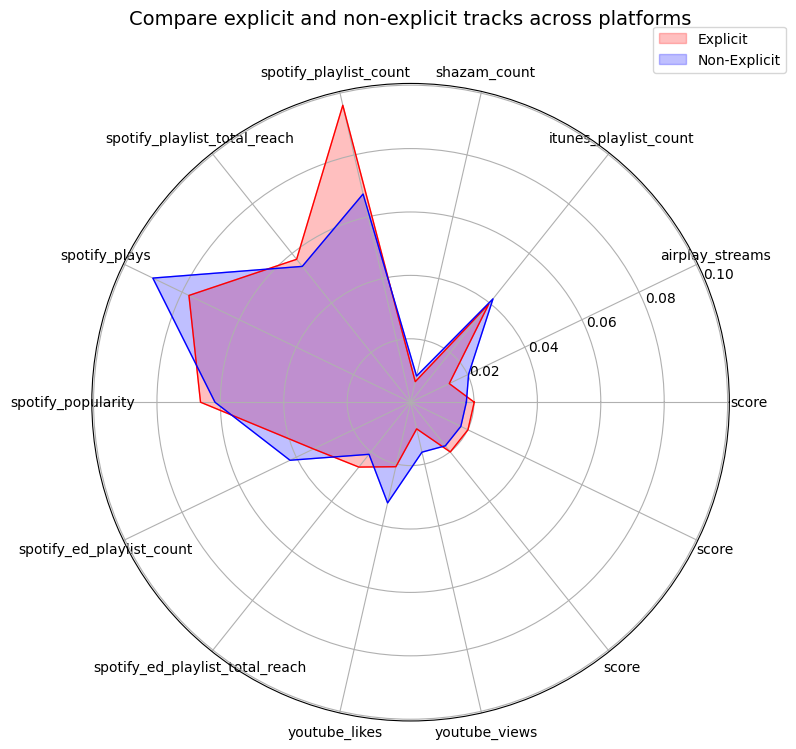

In [531]:

explicit_stats = df_normalized[df_normalized['explicit'] == True][categories].mean()
non_explicit_stats = df_normalized[df_normalized['explicit'] == False][categories].mean()

explicit_stats['spotify_popularity'] = explicit_stats['spotify_popularity']*0.1
non_explicit_stats['spotify_popularity'] = non_explicit_stats['spotify_popularity']*0.1

explicit_values = explicit_stats.values
non_explicit_values = non_explicit_stats.values

explicit_values = np.concatenate((explicit_values, [explicit_values[0]]))
non_explicit_values = np.concatenate((non_explicit_values, [non_explicit_values[0]]))
categories = np.concatenate((categories, [categories[0]]))

N = len(categories) - 1

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, explicit_values, color='red', alpha=0.25, label='Explicit')
ax.plot(angles, explicit_values, color='red', linewidth=1)

ax.fill(angles, non_explicit_values, color='blue', alpha=0.25, label='Non-Explicit')
ax.plot(angles, non_explicit_values, color='blue', linewidth=1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories[:-1], rotation=45)

plt.title('Compare explicit and non-explicit tracks across platforms', size=14, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()

##### Conclusion

The radar chart reveals that non-explicit tracks generally receive higher views, likes, and playbacks across multiple platforms, indicating a broader audience appeal.   

However, explicit tracks tend to perform better on Spotify, particularly in playlist placements, suggesting that a significant portion of Spotify's curated and user-generated playlists include explicit content.  

This highlights a key insight: while non-explicit tracks gain more visibility and engagement across diverse platforms, explicit tracks benefit from a stronger presence within Spotify's ecosystem, potentially due to user preferences or platform-specific playlist curation strategies.